# State Machine Simulation

This example shows how to use Python library
[python-statemachine](https://python-statemachine.readthedocs.io/en/latest/)
to simulate a state machine defined in a SysML file. Since the example is large,
we do not show all code inline. To see all files, please download the example
[from here](%DOWNLOAD-LINK%).

## Running The Example

To try the example, please download this Jupyter notebook and accompanying files
[from here](%DOWNLOAD-LINK%). You should unzip the archive in a folder within
the VS Code workspace. To run the example, open `example_notebook.ipynb` file in
VS Code. If you have not installed VS Code Python extensions yet, VS Code should
prompt you to install them. Follow the installation instructions. Once the
extensions are installed, when you open `example_notebook.ipynb` file, VS Code
should show “Run All” button at the top of the tab. Click on it to run the
example. VS Code may prompt you to install Python packages needed to run Jupyter
notebooks, please install them. After installing the dependencies, click on “Run
All” button again to run the example.

If VSCode asks you to choose the Python interpreter and you are using a virtual
environment, choose the one which includes `.venv` in its path.

### NOTE

Before running this example, make sure you have activated the SysIDE license by
running ``syside-license check`` according to the instructions in the
[License Activation](https://docs.sensmetry.com/latest/automator/install.html#license-activation)
section.


## Install Dependencies

Download [Graphviz](https://www.graphviz.org/download/)


The following command installs the Python packages needed to run this Jupyter
notebook. Annotation `%%capture pip` instructs Jupyter to hide the output. To
see the output, comment out that line.


In [1]:
%%capture pip
%pip install -r requirements.txt qq

In [2]:
assert (
    "ERROR" not in pip.stdout  # type: ignore # noqa: F821
), f"Installation of PIP packages failed:\n{pip.stdout}"  # type: ignore # noqa: F821

Import all dependencies needed for the example.


In [3]:
import syside
import base64
import pathlib
import os
import imageio
import numpy as np
import pandas
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
from collections import Counter
from sm_helpers import (
    StateMachine,
    render_state_machine,
    render_graph_to_file,
    sensor_readings_generator,
)
from syside_helpers import (
    get_node,
    set_feature_value,
    pprint_sysml,
)

## Model


In [4]:
MODEL = "example_model.sysml"
EXAMPLE_DIR = pathlib.Path(os.getcwd())
MODEL_FILE_PATH = EXAMPLE_DIR / MODEL

(model, diagnostics) = syside.load_model([MODEL_FILE_PATH])
assert not diagnostics.contains_errors(warnings_as_errors=True)

In this example, we model the alarm system of a fridge that is supposed to
inform the user when they forgot to close the fridge door and the temperature in
the fridge raises to a level that poses a risk of food getting bad. We model the
alarm system as a state machine with three states:


In [5]:
lines = []
for state in model.nodes(syside.StateUsage):
    state_documentation = " ".join(
        documentation.body for documentation in state.documentation.collect()
    )
    lines.append(f"- State {state.declared_name}: {state_documentation}")
display(Markdown("\n".join(lines)))

- State green: The temperature in the fridge is as expected.
- State yellow: The temperature in the fridge is too high, but not critical yet.
- State red: The temperature in the fridge is critical, the food is going to get bad.

The transitions between these states are guarded by the values of the
temperature sensor:


In [6]:
lines = []
for transition in model.nodes(syside.TransitionUsage):
    trigger = transition.trigger_action
    assert trigger
    payload = trigger.payload_argument
    assert payload
    guard = pprint_sysml(payload.children[0][1])
    source, target = transition.source, transition.target
    assert source
    assert target
    lines.append(
        f"- Transition from {source.declared_name} to {target.declared_name} with guard: `{guard}`"
    )
display(Markdown("\n".join(lines)))

- Transition from green to yellow with guard: `readSensors.temp >= YellowThreshold and readSensors.temp < RedThreshold
`
- Transition from green to red with guard: `readSensors.temp >= RedThreshold
`
- Transition from yellow to green with guard: `readSensors.temp < YellowThreshold
`
- Transition from yellow to red with guard: `readSensors.temp >= RedThreshold
`
- Transition from red to green with guard: `readSensors.temp < YellowThreshold
`

`RedThreshold` and `YellowThreshold` are constants defined in the model:


In [7]:
display(
    Markdown(
        f"""
```
{pprint_sysml(get_node(model, ["Demo", "Fridge_Signals", "YellowThreshold"]))}
{pprint_sysml(get_node(model, ["Demo", "Fridge_Signals", "RedThreshold"]))}
```
"""
    )
)


```
attribute YellowThreshold = 6;

attribute RedThreshold = 9;

```


While `readSensors.temp` is a result of an action:


In [8]:
display(
    Markdown(
        f"""
```
{pprint_sysml(get_node(model, ["Demo", "Fridge_Actions", "readSensors"]))}
```
"""
    )
)


```
action readSensors {
  out temp : Integer;
}

```


In file `sm_helpers.py` ([download archive](%DOWNLOAD-LINK%)), we provide a
class `StateMachine` that enables us to convert a SysML state machine to a state
machine based on Python library
[python-statemachine](https://python-statemachine.readthedocs.io/en/latest/).
Class `StateMachine` is instantiated by giving it the SysML element that
represents the state machine, which in our case has the qualified name
`Demo::Fridge_Diagnostic::DiagnosticStates`. To retrieve this element we use the
helper function `get_node` defined in file `syside_helpers.py`.


In [9]:
state_machine_node = get_node(
    model, ["Demo", "Fridge_Diagnostic", "DiagnosticStates"]
).cast(syside.StateDefinition)
state_machine = StateMachine(model, state_machine_node)
py_state_machine = state_machine.create_python_state_machine(
    allow_event_without_transition=True
)

One feature provided by `python-statemachine` is rendering of state machines using graphviz:


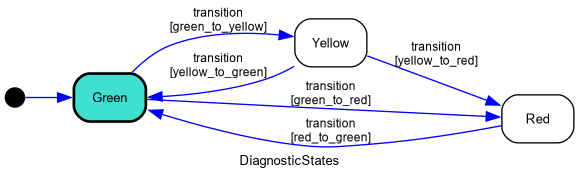

In [10]:
render_state_machine(py_state_machine)

## Simulation

Converting the state machine to Python also enables us to execute it on sample
inputs. Our state machine has one input parameter of type `int`
`Demo::Fridge_Actions::readSensors::temp`. We defined function
`sensor_readings_generator`, which generates a sequence of random temperature
readings. For example:


In [11]:
list(sensor_readings_generator(seed=123, count=3))

[{('Demo', 'Fridge_Actions', 'readSensors', 'temp'): 3},
 {('Demo', 'Fridge_Actions', 'readSensors', 'temp'): 2},
 {('Demo', 'Fridge_Actions', 'readSensors', 'temp'): 7}]

To execute the state machine, we have to evaluate the transition guards. We
evaluate a transition guard in two steps. First, we set the value of
`readSensors.temp` to the one we received from our random reading generator,
which makes the guard statically evaluatable:


In [12]:
set_feature_value(model, ("Demo", "Fridge_Actions", "readSensors", "temp"), 1)
display(
    Markdown(
        f"""
```
{pprint_sysml(get_node(model, ["Demo", "Fridge_Actions", "readSensors"]))}
```
"""
    )
)


```
action readSensors {
  out temp : Integer = 1;
}

```


Second, we use the constant evaluator `syside.Compiler` to evaluate the value of the guard:


In [13]:
compiler = syside.Compiler()
first_transition = list(model.nodes(syside.TransitionUsage))[0]
trigger = first_transition.trigger_action
assert trigger
payload = trigger.payload_argument
assert payload
expression = (
    payload.children[0][1].cast(syside.Feature).feature_value_expression
)
assert expression
value, report = compiler.evaluate(expression)
assert not report.fatal, str(report.diagnostics)
display(
    Markdown(
        f"""
Guard `{pprint_sysml(expression)}` evaluates to `{value}`.
"""
    )
)


Guard `readSensors.temp >= YellowThreshold and readSensors.temp < RedThreshold
` evaluates to `False`.


With these building blocks we can simulate how our state machine behaves on a
sequence of random temperature readings generated by
`sensor_readings_generator`.

The following code snippet executes the state machine on 20 randomly generated
inputs, logs each input and the resulting state, and renders the state of the
machine as a PNG image. The evaluation of transition guards is hidden inside the
implementation of class `StateMachine`.


In [14]:
from PIL import Image, ImageDraw

state_list = []
sensor_values = []
image_paths = []
for step, sensor_value in enumerate(sensor_readings_generator(123, 20)):
    sensor_values.append(sensor_value)
    py_state_machine.send("transition", sensor_value)
    state_list.append(py_state_machine.current_state_value)
    image_path = f"fridge_state_{step:02}.png"
    render_graph_to_file(py_state_machine, image_path)
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)
    text_color = (0, 0, 0)  # Black
    text_position = (10, 10)
    draw.text(
        text_position,
        f"Step: {step} Temp: {sensor_value[('Demo', 'Fridge_Actions', 'readSensors', 'temp')]}",
        fill=text_color,
    )
    image.save(image_path)
    image_paths.append(image_path)

Now, we can convert the generated PNG images into a GIF to get a simple
animation that shows the execution of the state machine (note that generating a
GIF is just one of many ways to create animations in Jupyter notebooks, for example, )


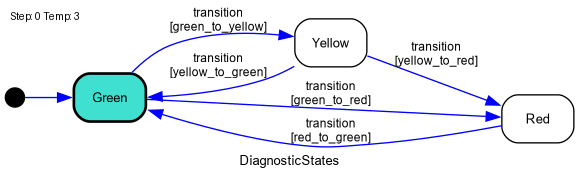

In [ ]:
GIF_FILE = "fridge_state_animation.gif"
with imageio.get_writer(GIF_FILE, mode="I", duration=1000, loop=0) as writer:
    for png_file in image_paths:
        data = imageio.v3.imread(png_file)
        writer.append_data(data)  # type: ignore
with open(GIF_FILE, "rb") as f:
    file_content = f.read()
base64_encoded_gif = base64.b64encode(file_content).decode("utf-8")
display(
    Markdown(
        f"![Rendered simulation](data:image/gif;base64,{base64_encoded_gif})"
    )
)

In addition to visually seeing how the state machine executes, we can analyze in
which states it spent most of its time.


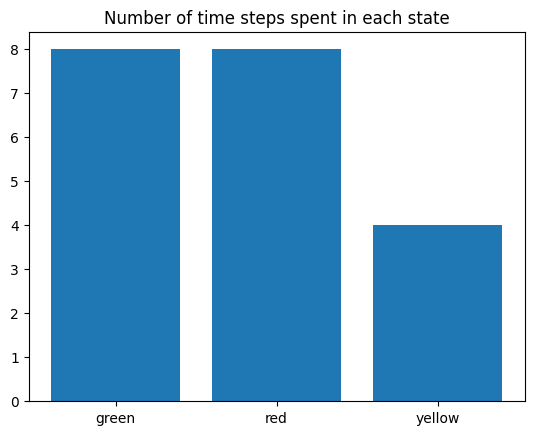

In [16]:
state_counts = Counter(state_list)
common = state_counts.most_common()
labels = [item[0] for item in common]
number = [item[1] for item in common]
plt.bar(np.arange(len(common)), number, tick_label=labels)
plt.title("Number of time steps spent in each state")
plt.show()

As we can see from the barchart, the state machine spent most of its time in red
state, which means that most of its time the fridge alarm was beeping, which is
potentially an undesired behavior.

To understand why this the red state is so prominent, we can look at the
detailed log:


In [17]:
pandas.DataFrame(
    [
        dict(sensor_value, state=state)
        for (sensor_value, state) in zip(sensor_values, state_list)
    ]
)

,"(Demo, Fridge_Actions, readSensors, temp)",state
0,3,green
1,2,green
2,7,yellow
3,8,yellow
4,7,yellow
5,3,green
6,1,green
7,4,green
8,9,red
9,12,red


From the log we can see that we have periods of time when the temperature does
not rise anymore and eventually starts dropping, but the state machine still
stays in red state signaling that the fridge user should do something even
though they potentially already closed the fridge door. Therefore, from this
simulation we can see that our state machine that only relies on temperature
readings is not good enough and probably we should also take into account
whether the fridge door is open or not.

We leave it as exercise to the reader to experiment improving the model.


## Download

Download this example [here](%DOWNLOAD-LINK%).
